# Data Pipeline

1.  face images were web-scraped from [Polk County](https://apps.polkcountyiowa.gov/PolkCountyInmates/CurrentInmates/), which is __no longer valid__ (_updated on 2020-07-24_)    
2. combine meta data
3. preprocess and Height, Weight and derive BMI

In [1]:
import pandas as pd
import os
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## original data before clean

In [2]:
data = pd.read_csv('/Users/bitanpaul/Documents/GitHub/face2bmi/data/full.csv')
data.head()

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid
0,7482,JAMES DEYO ROBINSON,3/10/2017 10:05:55 AM,"WAUKEE, IA",PCJ,54,"5' 11""",280,Black,Male,Brown,Black,248038
1,754952,CORDERRO ALTON LAURENCE,4/23/2017 8:57:43 AM,"DES MOINES, IA",Cherokee Mental Health,26,"5' 11""",210,Black,Male,Brown,Black,250464
2,644421,TAYLOR LOUIS HARLAN,12/7/2017 4:00:07 PM,"DES MOINES, IA",PCJ,24,"5' 09""",290,White,Male,Green,Blonde,263711
3,699804,MALIK TYRONE MANDUJANO,4/1/2018 3:24:44 AM,"DES MOINES, IA",PCJ,21,"5' 03""",130,Black,Male,Brown,Black,270020
4,238047,DUSTIN GLEN BLACK,8/5/2018 9:26:54 PM,"DES MOINES, IA",PCJ,29,"6' 02""",230,White,Male,Blue,Blonde,277774


In [3]:
# regex to extract feet and inches from height
regex_feet = re.compile("([0-9]+)\'")
regex_inches = re.compile("([0-9]+)\"")

def extract_numbers(x, regex):
    captures = regex.findall(x)
    if len(captures) > 0:
        try:
            return int(captures[0])
        except:
            return None
    else:
        return None
    
# parse the height string to feet and inches
data['feet'] = data['height'].map(lambda i: extract_numbers(i, regex_feet))
data['inches'] = data['height'].map(lambda i: extract_numbers(i, regex_inches))
data.loc[data.inches > 12,:]

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid,feet,inches
31,1083884,CALEB CHARLES RUTAN,1/2/2019 6:27:40 AM,"DES MOINES, IA",PCJ,48,"6' 63""",200,White,Male,Brown,Gray,287593,6.0,63.0
456,912542,HUSSEIN NKUSU TAMBWE,7/4/2019 10:40:46 AM,"URBANDALE, IA",PCJ,24,"5' 57""",175,Black,Male,Brown,Black,296374,5.0,57.0
566,1169382,JULIANNE JO BECKETT,7/15/2019 4:50:55 PM,"KNOXVILLE, IA",PCJ,20,"5' 59""",350,White,Female,Hazel,Brown,296977,5.0,59.0
622,1227456,ANDREW LANTA BOYD,7/19/2019 8:11:17 AM,"DES MOINES, IA",PCJ,35,"5' 59""",0,Black,Male,Brown,Black,297206,5.0,59.0
640,877215,SIOUX HAWK HOFFNER,7/22/2019 6:51:56 PM,"DES MOINES, IA",PCJ,24,"4' 49""",90,Pacific Islander,Female,Brown,Brown,297380,4.0,49.0
671,1051124,JASON ALLAN BROWNING,7/24/2019 6:10:24 PM,"URBANDALE, IA",PCJ,41,"6' 60""",205,White,Male,Green,Brown,297503,6.0,60.0
1068,1012250,DARRYL ANTHONY HISHAW,10/6/2019 4:48:50 PM,"DES MOINES, IA",PCJ,26,"5' 56""",145,Black,Male,Brown,Black,301966,5.0,56.0
1192,1170588,KAY SAW,10/27/2019 4:21:49 PM,"DES MOINES, IA",PCJ,22,"5' 54""",120,Asian,Male,Brown,Black,303124,5.0,54.0


In [4]:
# found some incorrect inches, assume 63" to 6.3"
data['inches'] = data['inches'].map(lambda i: i / 10 if i > 12 else i)
# convert feet/inches to inches
data['height'] = data.apply(lambda row: row['feet'] * 12 + row['inches'], axis=1)
# covert inches to m
data['height'] = data['height'].map(lambda i: i * 2.54 / 100)
# weight pounds => kg
data['weight'] = data['weight'].map(lambda i: i * 0.453592)
# calculate BMI = weight/height^2
data['bmi'] = data.apply(lambda row: row['weight'] / row['height'] / row['height'], axis = 1)
# create gender (number format of sex)
data['gender'] = data['sex'].map(lambda i: 1 if i == 'Male' else 0)

data[['nameid','age','height','weight','race','sex','eyes','hair', 'bmi']].head()

,nameid,age,height,weight,race,sex,eyes,hair,bmi
0,7482,54,1.8034,127.00576,Black,Male,Brown,Black,39.051641
1,754952,26,1.8034,95.25432,Black,Male,Brown,Black,29.288731
2,644421,24,1.7526,131.54168,White,Male,Green,Blonde,42.825039
3,699804,21,1.6002,58.96696,Black,Male,Brown,Black,23.028211
4,238047,29,1.8796,104.32616,White,Male,Blue,Blonde,29.529925


## Descriptive Analysis

In [5]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12

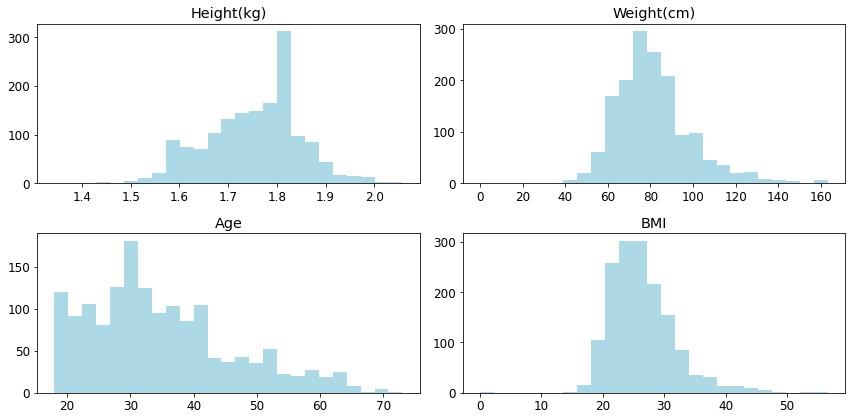

In [6]:
def ax_subplot(ax, x, title, bins = 25, color = 'lightblue'):
    x = x[~x.isnull()]
    ax.hist(x, bins = bins, color = color)
    ax.set_title(title)
    
fig, ax = plt.subplots(2,2)
ax_subplot(ax[0,0], data.height, 'Height(kg)')
ax_subplot(ax[0,1], data.weight, 'Weight(cm)')
ax_subplot(ax[1,0], data.age, 'Age')
ax_subplot(ax[1,1], data.bmi, 'BMI')
plt.tight_layout()
plt.show()

###  BMI density by Sex

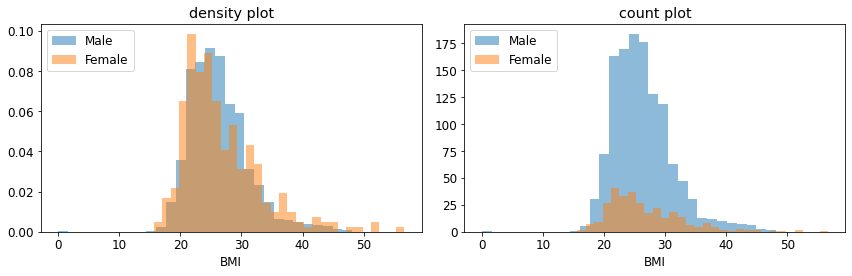

In [7]:
fig, ax = plt.subplots(1,2,sharex=True)
fig.set_size_inches(12,4)
options = {'density plot': True, 'count plot': False}

for i, (title, normed) in enumerate(options.items()):

    for sex in ['Male','Female']:
        ax[i].hist(data.loc[(data.sex == sex) & (~data.bmi.isnull()),'bmi'].values, label = sex, alpha = 0.5, 
                 bins = 30, density = normed)
        ax[i].set_title(title)
        ax[i].set_xlabel('BMI')
        ax[i].legend(loc = 'upper left')
        
plt.tight_layout()        
plt.show()

### Gender and Race Imbalance

<AxesSubplot:xlabel='count', ylabel='race'>

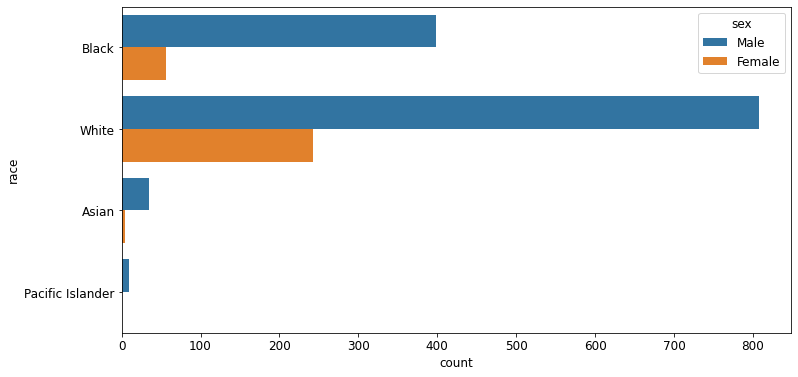

In [8]:
sns.countplot(y = 'race' ,data = data, hue = 'sex')

## split train / valid data

In [9]:
# remove rows that no face images
data['index'] = data['bookid'].map(lambda i: str(i) +'.jpg')
allimage = os.listdir('./data/face/')
data = data.loc[data['index'].isin(allimage),:]

# remove rows with invalid BMI
data = data.loc[~data['bmi'].isnull(), :]

# split train/valid
in_train = np.random.random(size = len(data)) <= 0.8
train = data.loc[in_train,:]
test = data.loc[~in_train,:]

print('train data dimension: {}'.format(str(train.shape)))
print('test data dimension:  {}'.format(str(test.shape)))

# output to csv files
train.to_csv('./data/train.csv', index = False)
test.to_csv('./data/valid.csv', index = False)

train data dimension: (1225, 18)
test data dimension:  (318, 18)
